In [1]:
import numpy as np
from ase.io import read

import abtem
from abtem.special_structures import graphene_bilayer
from abtem.structures import orthogonalize_cell
from abtem.potentials import Potential
from abtem import show_atoms

from abtem import SMatrix, Potential, GridScan, AnnularDetector, PixelatedDetector, Measurement

import matplotlib.pyplot as plt

#import cupy

In [2]:
device = 'cpu'

if device == 'gpu':
    # We disable FFT planning cache on GPU due to its high memory cost.
    from cupy.fft.config import get_plan_cache, show_plan_cache_info
    cache = get_plan_cache()
    cache.set_size(0)

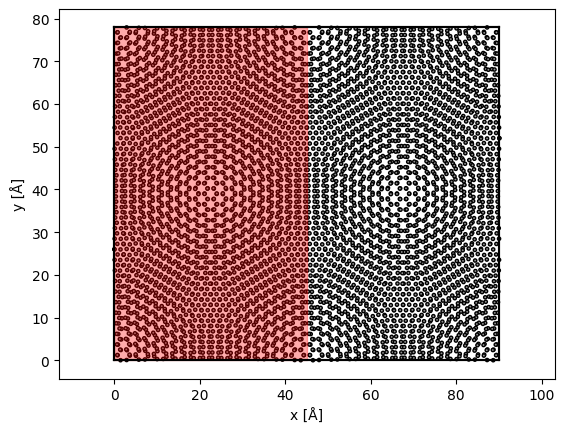

In [4]:
## load structure (from: https://doi.org/10.1002/smll.202100388) ##

atoms = read('data/interferometric_example/gra_3.15deg_bilayer_relaxed.cif')
atoms = orthogonalize_cell(atoms)
atoms *= (2,1,1)

atoms.center(axis=2, vacuum=5)
gridscan = GridScan((0,0),(atoms.cell[0,0] / 2, atoms.cell[1,1]), sampling=.2)
show_atoms(atoms, scans = gridscan);

In [5]:
## create potential ##

potential = Potential(atoms, gpts=1024).build()

## simulate MAADF image ##

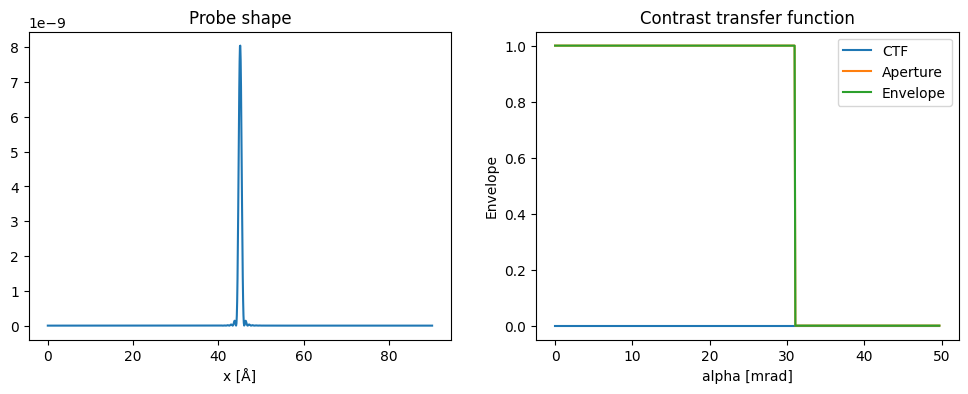

In [7]:
S = SMatrix(semiangle_cutoff=31, # mrad
            energy=60e3, # eV
            defocus=0, # Angstrom
            rolloff=0.02, # soften aperture 2 %
            interpolation=8,
            device=device,
            storage='cpu')

S.grid.match(potential)

gridscan.sampling = .9 * S.ctf.nyquist_sampling

equivalent_probe = S.get_equivalent_probe()

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
equivalent_probe.profile().show(ax=ax1);
ax1.set_title('Probe shape')
S.ctf.show(ax=ax2);
ax2.set_title('Contrast transfer function');

In [8]:
print('Scan sampling:', gridscan.sampling, 'Å')
print('Max scattering angle:', S.cutoff_scattering_angles, 'mrad')
print('Real space sampling:', S.sampling, 'Å')

Scan sampling: (0.351875, 0.3529935220493314) Å
Max scattering angle: (183.6656893032315, 182.1383327860812) mrad
Real space sampling: (0.08796875178813934, 0.07618317008018494) Å


In [9]:
## define detector properties ##

detector = AnnularDetector(inner=60, outer=80, save_file='interferometric-simulation-data/maadf_3_15_20231010.hdf5')
measurement = S.scan(gridscan, detector, potential)

Multislice:   0%|          | 0/143 [00:00<?, ?it/s]

Scan:   0%|          | 0/28288 [00:00<?, ?it/s]

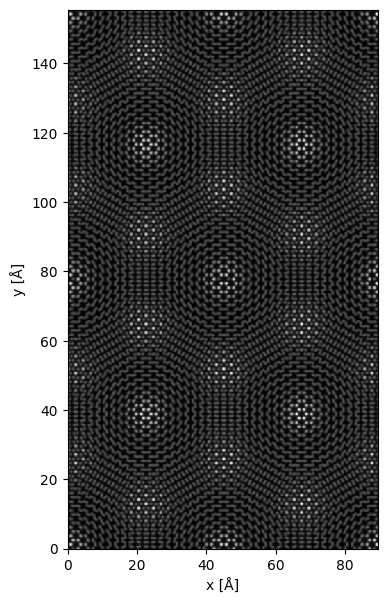

In [80]:

measurement = Measurement.read('interferometric-simulation-data/maadf_3_15_20231010.hdf5') 
measurement.interpolate(.2).tile((2,2)).show(figsize=(7,7));


In [81]:
cropped_measurement = measurement.interpolate(.2).tile((2,2)).crop((80,80), origin=(0,0))

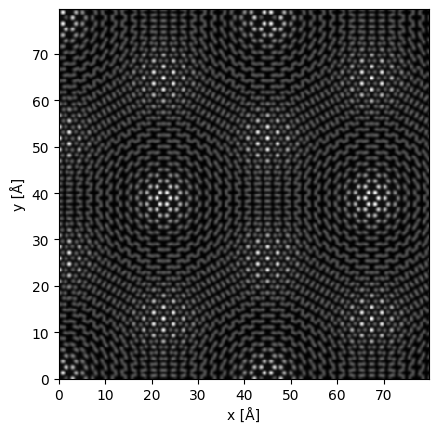

In [82]:
cropped_measurement.show();

In [83]:
from abtem.noise import poisson_noise

In [84]:
noisy = poisson_noise(cropped_measurement, dose=5e5)

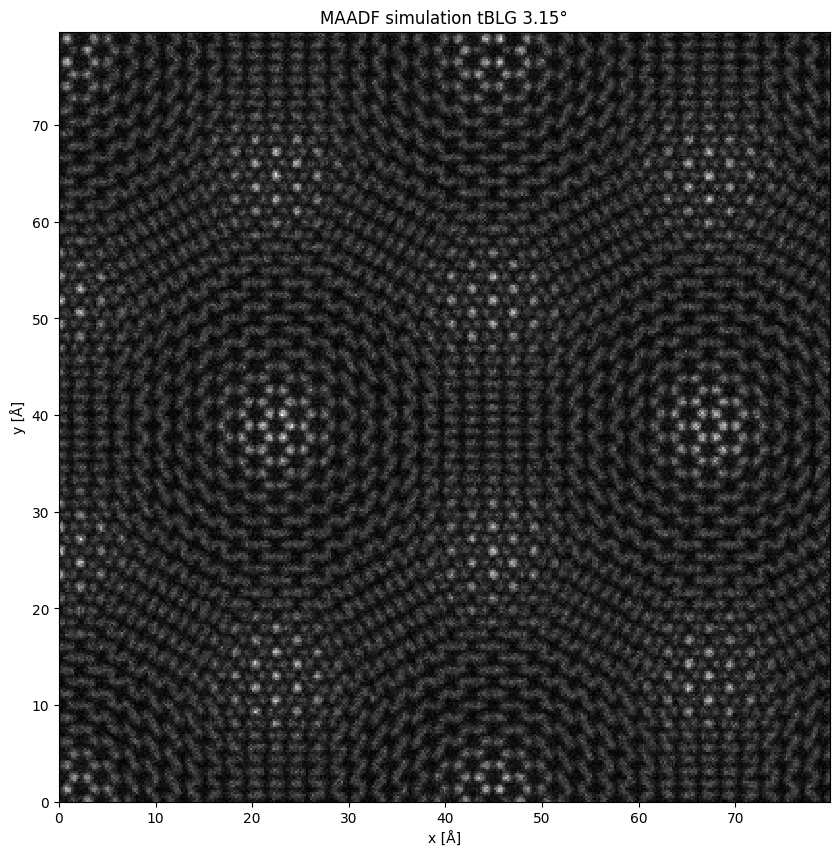

In [85]:
fig, axs = plt.subplots(figsize=(10,10))
noisy.show(ax = axs, title='MAADF simulation tBLG 3.15°');
plt.savefig('interferometric-simulation-data/maadf_3_15.pdf')

In [87]:
noisy.save_as_image('interferometric-simulation-data/maadf_3_15_20231010.tif')

## Interferometric 4D STEM simulations ##

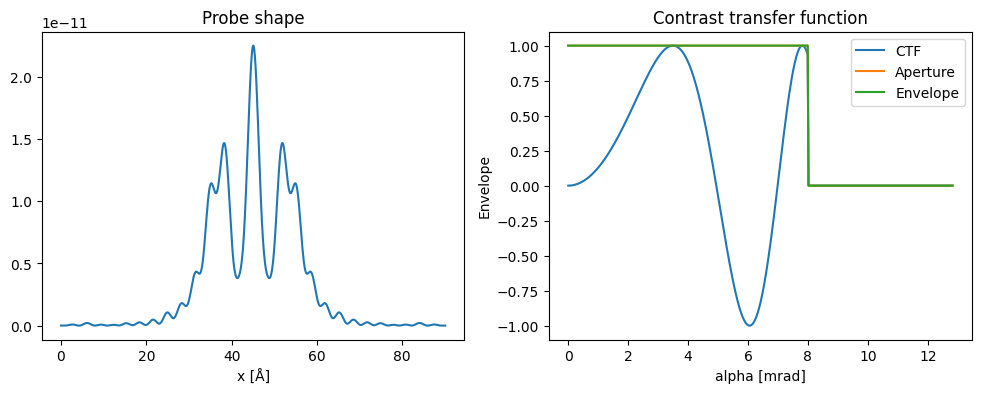

In [6]:
S = SMatrix(expansion_cutoff=8, # mrad
            semiangle_cutoff=8, # mrad
            energy=60e3, # eV
            defocus=2000, # Angstrom
            rolloff=0.02, # soften aperture 2 %
            interpolation=1, # no interpolation, we want good Fourier space sampling
            device=device,
            storage='cpu')

S.grid.match(potential)

gridscan.sampling = .9 * S.ctf.nyquist_sampling

equivalent_probe = S.get_equivalent_probe()

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
equivalent_probe.profile().show(ax=ax1);
ax1.set_title('Probe shape')
S.ctf.show(ax=ax2);
ax2.set_title('Contrast transfer function');



In [7]:
print('Scan sampling:', gridscan.sampling, 'Å')
print('Max scattering angle:', S.cutoff_scattering_angles, 'mrad')
print('Real space sampling:', S.sampling, 'Å')

Scan sampling: (1.3648484848484848, 1.3686240065421444) Å
Max scattering angle: (184.20588250706453, 184.32149773385962) mrad
Real space sampling: (0.08796875178813934, 0.07618317008018494) Å


In [8]:
S_array = S.multislice(potential, pbar=True)

Multislice:   0%|          | 0/27 [00:00<?, ?it/s]

Plane waves:   0%|          | 0/597 [00:00<?, ?it/s]

In [9]:
S_array_down = S_array.downsample(max_angle=60) # mrad

In [10]:
detector = PixelatedDetector(save_file='interferometric-simulation-data/4dstem_data_3_15_20231011.hdf5')
measurement = S_array_down.scan(gridscan, detector, max_batch_probes=500)


Scan:   0%|          | 0/1881 [00:00<?, ?it/s]

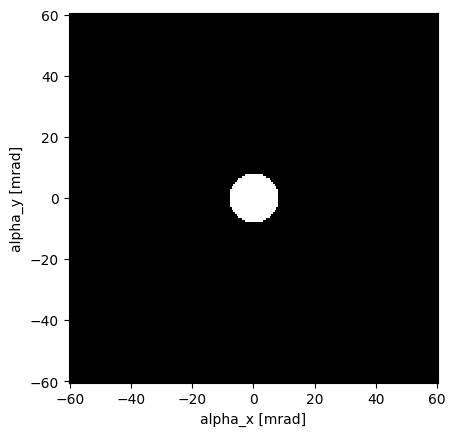

In [15]:
from abtem.measure import center_of_mass, bandlimit

measurement = Measurement.read('interferometric-simulation-data/4dstem_data_3_15_20231011.hdf5')
measurement[10,10].show();

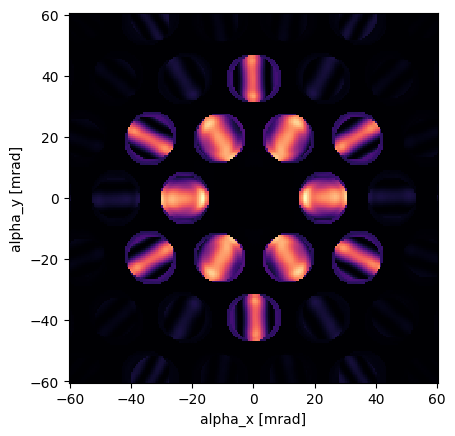

In [16]:
bandlimit(measurement,cutoff=10,band_type='highpass')[0,0].show(cmap='magma');

In [17]:

def crop(measurement, extent: tuple[float, float, float, float], origin: tuple[float, float, float, float] = (0.0, 0.0, 0.0, 0.0)):
    """
    Crop images to a smaller extent.

    Parameters
    ----------
    extent : tuple of float
        Extent of rectangular cropping region in `x` and `y` [Å].
    offset : tuple of float
        Lower corner of cropping region in `x` and `y` [Å] (default is (0,0)).

    Returns
    -------
    cropped_images : Images
        The cropped images.
    """

    origin = [
        int(np.round(measurement.shape[0] * origin[0] / (measurement.shape[0]*measurement.calibrations[0].sampling))),
        int(np.round(measurement.shape[1] * origin[1] / (measurement.shape[1]*measurement.calibrations[1].sampling))),
        int(np.round(measurement.shape[2] * origin[2] / (measurement.shape[2]*measurement.calibrations[2].sampling))),
        int(np.round(measurement.shape[3] * origin[3] / (measurement.shape[3]*measurement.calibrations[3].sampling)))
    ]
    new_shape = [
        int(np.round(measurement.shape[0] * extent[0] / (measurement.shape[0]*measurement.calibrations[0].sampling))),
        int(np.round(measurement.shape[1] * extent[1] / (measurement.shape[1]*measurement.calibrations[1].sampling))),
        int(np.round(measurement.shape[2] * extent[2] / (measurement.shape[2]*measurement.calibrations[2].sampling))),
        int(np.round(measurement.shape[3] * extent[3] / (measurement.shape[3]*measurement.calibrations[3].sampling)))
    ]
    if new_shape[0] != new_shape[1]:
        new_shape[0] = max([new_shape[0], new_shape[1]])
        new_shape[1] = new_shape[0]

    array = measurement.array[
        origin[0] : origin[0] + new_shape[0],
        origin[1] : origin[1] + new_shape[1],
        origin[2] : origin[2] + new_shape[2],
        origin[3] : origin[3] + new_shape[3],
    ]
    
    
    calibrations = measurement.calibrations
    units = measurement.units
    name = measurement.name
    
    return abtem.Measurement(array, calibrations, units, name)

In [20]:
cropped = crop(measurement.tile((2,2,1,1)), (80,80,120,120), origin=(0,0,0,0))

In [21]:
cropped.write('interferometric-simulation-data/cropped_4dstem_data_3_15_20231011.hdf5')

'interferometric-simulation-data/cropped_4dstem_data_3_15_20231011.hdf5'

In [22]:
cropped.shape

(59, 59, 222, 192)

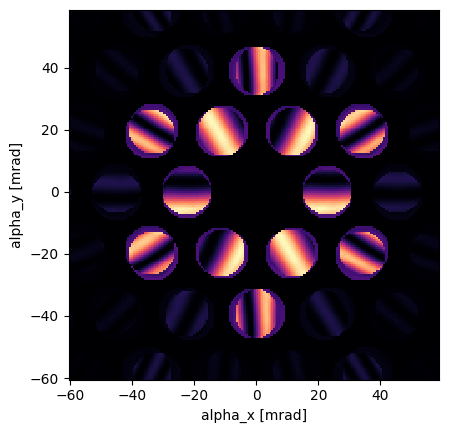

In [23]:
bandlimit(cropped,cutoff=10,band_type='highpass')[20,20].show(cmap='magma');
#cropped[0,0].show(cmap='magma');